Notebook to develop calculations for barotropic to baroclinic conversion,

$ C = <p'(-H) \vec{U}\cdot\nabla H>$

where $p'$ is pressure perturbation, $\vec{U}$ is barotropic velocity, $H$ is bottom topography. So bottom depth is z = -H(x,y)

$ p' = \int_z^0 N^2\zeta dz' - \frac{1}{H} \int_{-H}^0 \int_z^0 N^2\zeta dz' dz$

and $\zeta$ is isopycncal displacement. $<>$ denote an average over a tida period. See Carter et al (2008), Energetics of M2 Barotropic to Baroclinic Tidal Conversion at the Hawaiian Islands

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

from nowcast import analyze
from salishsea_tools import viz_tools

import gsw

%matplotlib inline

In [2]:
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

bathy = grid.variables['Bathymetry'][:]

## Calculate bathymetry gradient

In [3]:
def bathymetry_gradient(bathy, mesh):
    e1t = mesh.variables['e1t'][0,:,:]
    e2t = mesh.variables['e2t'][0,:,:]
    
    diff_x = bathy[:,1:] - bathy[:,:-1]
    diff_y = bathy[1:,:] - bathy[:-1.:]
    hx = np.concatenate([np.zeros((bathy.shape[0],1)), diff_x], axis=1) #pad with zeros in first row
    hy = np.concatenate([np.zeros((1, bathy.shape[1])), diff_y], axis=0) # pad with zeros in first column
    
    return hx, hy

In [4]:
hx, hy = bathymetry_gradient(bathy, mesh)

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3114: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3169: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]


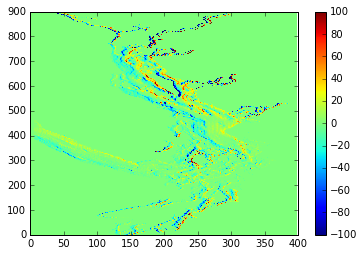

In [5]:
plt.pcolormesh(-hx,vmin=-100,vmax=100)
plt.colorbar()

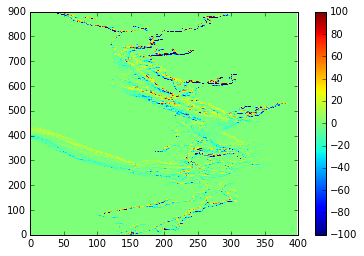

In [6]:
plt.pcolormesh(-hy,vmin=-100,vmax=100)
plt.colorbar()

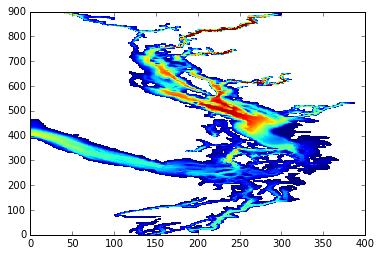

In [7]:
plt.pcolormesh(bathy)

Check that barortopic w makes sense

In [8]:
fU = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_U.nc')
fV = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_V.nc')
u = fU.variables['vozocrtx'][:]
v = fV.variables['vomecrty'][:]
umask = mesh.variables['umask'][:] + np.zeros(u.shape)
vmask = mesh.variables['vmask'][:] + np.zeros(v.shape)
tmask = mesh.variables['tmask'][:]
e3t = mesh.variables['e3t'][:]
e3u = mesh.variables['e3u'][:]
e3v = mesh.variables['e3v'][:]

u_depav = analyze.depth_average_mask(u,e3u[0,:,:,:], umask[0,:,:,:], depth_axis=1)
v_depav = analyze.depth_average_mask(v,e3v[0,:,:,:], vmask[0,:,:,:], depth_axis=1)

udepav_m = np.ma.masked_array(u_depav, mask = 1-umask[:,0,:,:])
vdepav_m = np.ma.masked_array(v_depav, mask = 1-vmask[:,0,:,:])
udepav_s,vdepav_s = viz_tools.unstagger(udepav_m,vdepav_m)

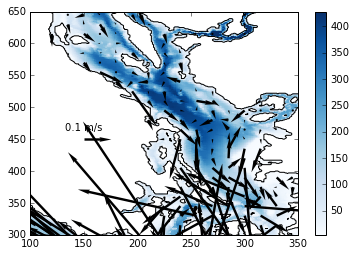

In [9]:
st=15
t=12
xx, yy = np.meshgrid(np.arange(v_depav.shape[-1]), np.arange(v_depav.shape[-2]))
fig,ax=plt.subplots(1,1)
mesh=ax.pcolormesh(bathy,cmap='Blues')
mesh=plt.colorbar(mesh,ax=ax)
q=ax.quiver(xx[::st,::st],yy[::st,::st],udepav_s[t,::st,::st],vdepav_s[t,::st,::st],scale=1,
            color='k',width=0.009,headwidth=2,)
ax.quiverkey(q,150,450,.1,'0.1 m/s', color='k',coordinates='data')
ax.set_xlim([100,350])
ax.set_ylim([300,650])
viz_tools.plot_coastline(ax,grid)

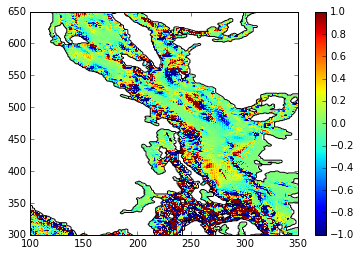

In [10]:
wB = -udepav_s*hx[1:,1:] + -vdepav_s*hy[1:,1:]
fig,ax=plt.subplots(1,1)
mesh=ax.pcolormesh(wB[t,:,:],vmin=-1,vmax=1)
plt.colorbar(mesh,ax=ax)
ax.set_xlim([100,350])
ax.set_ylim([300,650])
viz_tools.plot_coastline(ax,grid)

The barotropic vertical velocity is really noisy, especially in Boundary Pass where currents are large and bathymetry is complex and steep.  